In [78]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [79]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [80]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [81]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
               
                
               2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                }, 5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
                ,
               
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                },}
appliances = ["Refrigerator"]

In [82]:
print("######")
print("")
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis,skew
import copy



def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    x_train_mean = []
    x_train_std = []
    x_train_max_min = []
    x_train_main = []
    x_train_main_dif = []
    x_train_kurtosis = []
    x_train_skew = []
    x_train_max = []
    x_train_min = []
    n = 99
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    scaler_mean = StandardScaler()
    scaler_std = StandardScaler()
    scaler_max_min = StandardScaler()
    scaler_main = StandardScaler()
    scaler_diff = StandardScaler()
    scaler_kurtosis = StandardScaler()
    scaler_skew = StandardScaler()
    scaler_max = StandardScaler()
    scaler_min = StandardScaler()
    # GV - TRAIN
    os.chdir('/home/gautam.pv/nlim')
    print(f"cwd -> {os.getcwd()}")
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        print(f"Building number: {key}")
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values

        x_train_main.extend(x)
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))

        number_of_bins = len(x)-n+1
        x_original = copy.deepcopy(x)
        x = jnp.array([x[i: i + n] for i in range(number_of_bins)])
        #############
        # Only for Max and mins we choose smaller size window size
        new_widow_size = 99
        x_new = jnp.array([x_original[i: i + new_widow_size] for i in range(number_of_bins)]) 
        x_train_max.extend(jnp.max(x_new,axis=1))
        x_train_min.extend(jnp.min(x_new,axis=1))
        #################
        print(f'post_x_shape: {x.shape}')
        x_train_mean.extend(jnp.mean(x, axis=1))
        x_train_std.extend(jnp.std(x, axis=1))
        debug_x = jnp.std(x,axis=1)
        x_train_max_min.extend(jnp.max(x, axis=1)-jnp.min(x,axis=1))
        x_train_kurtosis.extend(kurtosis(x,axis=1))
        x_train_skew.extend(skew(x,axis = 1))
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))
    
    #################
    # TRAIN RESHAPING
    ##################
    print(f"Data from all building added")
    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    print(f"x_train_main_shape -> {len(x_train_main)}")
    print(f"x_train_std_shape => {len(x_train_std)}")
    x_train_main = jnp.array(x_train_main).reshape(-1,1)
    x_train_mean = jnp.array(x_train_mean).reshape(-1,1)
    x_train_std =  jnp.array(x_train_std).reshape(-1,1)
    x_train_max_min =  jnp.array(x_train_max_min).reshape(-1,1)
    x_train_kurtosis = jnp.array(x_train_kurtosis).reshape(-1,1)
    x_train_skew = jnp.array(x_train_skew).reshape(-1,1)
    x_train_max = jnp.array(x_train_max).reshape(-1,1)
    x_train_min = jnp.array(x_train_min).reshape(-1,1)
    print(f"final x_train_max_shape -> {x_train_max.shape}")
    print(f"final x_train_std shape -> {x_train_std.shape}")
   

    #################################################
        # Performing Transformations
    ##################################################
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)
    x_train_main = scaler_main.fit_transform(x_train_main)
    x_train_mean = scaler_mean.fit_transform(x_train_mean)
    x_train_std = scaler_std.fit_transform(x_train_std)
    x_train_max_min = scaler_max_min.fit_transform(x_train_max_min)
    x_train_kurtosis = scaler_kurtosis.fit_transform(x_train_kurtosis)
    x_train_skew = scaler_skew.fit_transform(x_train_skew)
    x_train_max = scaler_max.fit_transform(x_train_max)
    x_train_min = scaler_min.fit_transform(x_train_min)
    
    #############################################################################
    # TEST
    #############################################################################

    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_mean = []
    x_test_std = []
    x_test_max_min = []
    x_test_kurtosis = []
    x_test_skew = []
    x_test_timestamp_true =[]
    x_test_main = []
    x_test_max = []
    x_test_min = []

    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values 
        x_test_main.extend(x)
        y = df[appliances[0]].values

        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        number_of_bins = len(x)-n+1
        x_original = copy.deepcopy(x)
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
         #############
        # Only for Max and mins we choose smaller size window size
        new_widow_size = 99
        x_new = jnp.array([x_original[i: i + new_widow_size] for i in range(number_of_bins)]) 
        print(f"x_new shape -> ")
        x_test_max.extend(jnp.max(x_new,axis=1))
        x_test_min.extend(jnp.min(x_new,axis=1))
        #################

        x_test_mean.extend(jnp.mean(x, axis=1))
        x_test_std.extend(jnp.std(x, axis=1))
        x_test_max_min.extend(jnp.max(x, axis=1)-jnp.min(x, axis=1))
        x_test_kurtosis.extend(kurtosis(x,axis=1))
        x_test_skew.extend(skew(x,axis=1))
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)
    
    #############
    #  Flattening for test
    ##############
    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)
    x_test_main = jnp.array(x_test_main).reshape(-1,1)
    x_test_mean = jnp.array(x_test_mean).reshape(-1,1)
    x_test_std =  jnp.array(x_test_std).reshape(-1,1)
    x_test_max_min =  jnp.array(x_test_max_min).reshape(-1,1)
    x_test_kurtosis = jnp.array(x_test_kurtosis).reshape(-1,1)
    x_test_skew = jnp.array(x_test_skew).reshape(-1,1)
    x_test_max = jnp.array(x_test_max).reshape(-1,1)
    x_test_min = jnp.array(x_test_min).reshape(-1,1)
    print(f"final x_test_max_shape -> {x_test_max.shape}")
    print(f"final x_test_std shape -> {x_test_std.shape}")

    #############
    # Scalar tranformations for test
    #############
    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
    x_test_mean = scaler_mean.transform(x_test_mean)
    x_test_std = scaler_std.transform(x_test_std)
    x_test_max_min = scaler_max_min.transform(x_test_max_min)
    x_test_main = scaler_main.transform(x_test_main)
    x_test_kurtosis = scaler_kurtosis.transform(x_test_kurtosis)
    x_test_skew = scaler_skew.transform(x_test_skew)
    x_test_max = scaler_max.transform(x_test_max)
    x_test_min = scaler_min.transform(x_test_min)
    
    ######################
    # FINAL RESHAPING
    ######################

    x_train = jnp.array(x_train[:,1:]).reshape(x_train.shape[0], n-1)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test[:,1:]).reshape(x_test.shape[0], n-1)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    #############################
    # FINAL CONCATENATATION
    #############################

    num_features_selected = 6

    x_train_features = jnp.concatenate((x_train_main, x_train_mean, x_train_max_min,x_train_kurtosis,x_train_max,x_train_min), axis=1).reshape(x_train.shape[0], num_features_selected)
    x_test_features = jnp.concatenate((x_test_main, x_test_mean, x_test_max_min,x_test_kurtosis,x_test_max, x_test_min), axis=1).reshape(x_test.shape[0], num_features_selected)

    scalers = np.array([scaler_x, scaler_y, scaler_time, scaler_main, scaler_mean, scaler_std, scaler_max_min,scaler_max,scaler_min,scaler_kurtosis])
    return x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timestamp, x_test_timestamp, scalers, x_test_main


######



In [61]:
x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timstamp, x_test_timestamp, scalers, x_test_main = dataset_load(appliances, train, test)

cwd -> /home/gautam.pv/nlim
Building number: 1
post_x_shape: (19917, 99)
Building number: 3
post_x_shape: (14780, 99)
Building number: 2
post_x_shape: (15656, 99)
Building number: 5
post_x_shape: (3103, 99)
Data from all building added
x_train_main_shape -> 53456
x_train_std_shape => 53456
final x_train_max_shape -> (53456, 1)
final x_train_std shape -> (53456, 1)
x_new shape -> 
final x_test_max_shape -> (16781, 1)
final x_test_std shape -> (16781, 1)


### Visualization Block

Use this block if you want visualize the relevance of any featue

In [62]:
x_train_full = jnp.concatenate((x_train_features, jnp.array(np.array(x_train_timstamp))), axis=1)
x_test_full  = jnp.concatenate((x_test_features, jnp.array(np.array(x_test_timestamp))), axis=1)

In [49]:
# x_train_full = jnp.concatenate((x_train.reshape(-1,n), jnp.array(np.array(x_train_timstamp))), axis=1)
# x_test_full = jnp.concatenate((x_test.reshape(-1,n), jnp.array(np.array(x_test_timestamp))), axis=1)
# x_train_full.shape, x_test_full.shape

In [50]:
# x_train.reshape(-1,n).shape, x_test.reshape(-1,n).shape, y_train.shape, y_test.shape

In [51]:
# x = x_train_full[:14000]
# y = y_train[:14000]
# xt = x_train_full[14000:]
# yt = y_train[14000:]

In [52]:
# x.shape, y.shape

## Adding Diff as a feature

In [70]:

diff_scalar = StandardScaler()
x_train_diff = x_train_features[:,0]
train_diff = np.array(x_train_diff)
for i in range(1, len(x_train_diff)):
		value = x_train_diff[i] - x_train_diff[i - 1]
		train_diff[i] = value
x_train_diff = np.array(train_diff).reshape(-1,1)
x_train_diff = diff_scalar.fit_transform(x_train_diff)
x_test_diff = x_test_features[:,0]
test_diff = np.array(x_test_diff)
for i in range(1, len(x_test_diff)):
		value = x_test_diff[i] - x_test_diff[i - 1]
		test_diff[i] = value
x_test_diff = np.array(test_diff).reshape(-1,1)
x_test_diff = diff_scalar.transform(x_test_diff)
# x_train_zeros = np.zeros(x_train_diff.shape)
# x_test_zeros = np.zeros(x_test_diff.shape)
# x_train_diff = jnp.array(diff)

In [71]:
x_train_diff.shape,x_test_diff.shape

((53456, 1), (16781, 1))

In [72]:
x_train_features = jnp.concatenate((x_train_features,jnp.array(x_train_diff.reshape(-1,1))), axis=1)
x_test_features  = jnp.concatenate((x_test_features, jnp.array(x_test_diff.reshape(-1,1))),  axis=1)
x_train_features.shape,x_test_features.shape

((53456, 7), (16781, 7))

## Adding FFT as a Feature

((53456, 6), (16781, 6))

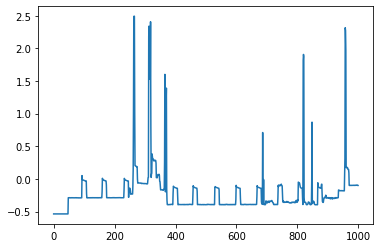

In [56]:
from scipy.fft import fft, fftfreq, fftshift

plt.plot(x_train[0:1000,0])
fft_scaler = StandardScaler()

window_size = 99
x_train_fft = x_train_features[:,0]
x_train_fft = fftshift(fftfreq(x_train_fft.shape[0]))
x_train_fft = x_train_fft.reshape(-1,1)
x_train_fft = fft_scaler.fit_transform(x_train_fft)

x_test_fft = x_test_features[:,0]
x_test_fft = fftshift(fftfreq(x_test_fft.shape[0]))
x_test_fft = x_test_fft.reshape(-1,1)
x_test_fft = fft_scaler.transform(x_test_fft)

x_train_features = jnp.concatenate((x_train_features,jnp.array(x_train_fft.reshape(-1,1))), axis=1)
x_test_features  = jnp.concatenate((x_test_features, jnp.array(x_test_fft.reshape(-1,1))),  axis=1)

x_train_features.shape,x_test_features.shape

## Training

In [73]:
import gpytorch
indexes = 53456
n = 7
x  = torch.tensor(np.array(x_train_features)).to(torch.float64)
y  = torch.tensor(np.array(y_train)).reshape(-1,).to(torch.float64)
xt = torch.tensor(np.array(x_test_features)).to(torch.float64)
yt = torch.tensor(np.array(y_test)).reshape(-1,).to(torch.float64)

if x.shape[0] > indexes:
    x = x[:indexes]
    y = y[:indexes]

# xt = xt[:16000]
# yt = yt[:16000]


In [74]:
x.dtype

torch.float64

In [75]:
x.shape, y.shape, xt.shape, yt.shape

(torch.Size([53456, 7]),
 torch.Size([53456]),
 torch.Size([16781, 7]),
 torch.Size([16781]))

## Training Loop

testing -> x.shape -> torch.Size([53456, 7])
testing -> x.shape -> torch.Size([53456])
restart: 0, epoch: 1, iter: 1, loss: 1.0168
restart: 0, epoch: 2, iter: 1, loss: 1.0156
restart: 0, epoch: 3, iter: 1, loss: 1.0147
restart: 0, epoch: 4, iter: 1, loss: 1.0137
restart: 0, epoch: 5, iter: 1, loss: 1.0128
restart: 0, epoch: 6, iter: 1, loss: 1.0120
restart: 0, epoch: 7, iter: 1, loss: 1.0111
restart: 0, epoch: 8, iter: 1, loss: 1.0103
restart: 0, epoch: 9, iter: 1, loss: 1.0095
restart: 0, epoch: 10, iter: 1, loss: 1.0087
restart: 0, epoch: 11, iter: 1, loss: 1.0079
restart: 0, epoch: 12, iter: 1, loss: 1.0072
restart: 0, epoch: 13, iter: 1, loss: 1.0065
restart: 0, epoch: 14, iter: 1, loss: 1.0057
restart: 0, epoch: 15, iter: 1, loss: 1.0050
restart: 0, epoch: 16, iter: 1, loss: 1.0043
restart: 0, epoch: 17, iter: 1, loss: 1.0036
restart: 0, epoch: 18, iter: 1, loss: 1.0030
restart: 0, epoch: 19, iter: 1, loss: 1.0023
restart: 0, epoch: 20, iter: 1, loss: 1.0016
restart: 0, epoch: 21,

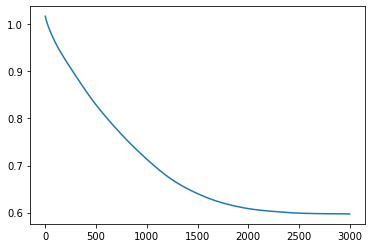

In [76]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512

# x_train = x_train[:4500]
# y_train = y_train[:4500]

# y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
periodicity_values = [0.01,0.02,0.03,0.04]
for i in range(1):
   #nu=2.5,
  kernel1 = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=n))
  # kernel2 = ScaleKernel(MaternKernel(nu=0.5,ard_num_dims=1,active_dims=(n)))
  # kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(n)))
  # kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1,active_dims=(n)))
  # kernel5 = ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(num_dims=n,ard_num_dims=n))
#   theta =  {'base_covar_module.kernels.0.base_kernel.lengthscale': torch.tensor(0.5),
#         'base_covar_module.kernels.0.outputscale': torch.tensor(5.0),
#         'base_covar_module.kernels.1.kernels.0.outputscale':torch.tensor(1.0),
#         'base_covar_module.kernels.1.kernels.0.base_kernel.lengthscale': torch.tensor(0.1),
#         'base_covar_module.kernels.1.kernels.1.outputscale':torch.tensor(1.0),
#         'base_covar_module.kernels.1.kernels.1.base_kernel.lengthscale': torch.tensor(1.0),
#         'base_covar_module.kernels.1.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
  theta = { 'base_covar_module.kernels.1.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
  # kernel4 = kernel2*kernel3
  kernel = kernel1 #+ kernel4
  # induce_points = 512
  # GV -  What are inducing points?
  inducing_points =  x[np.arange(0,x.shape[0],95)] 
  # inducing_points = x[torch.randperm(x.shape[0])[: 1500]]
  print(f"testing -> x.shape -> {x.shape}")
  print(f"testing -> x.shape -> {y.shape}")
  model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                       inducing_points).to("cuda")
  # model.base_covar_module.base_kernel.raw_lengthscale_constraint
  # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
  # for param in model.parameters():
  #   # print(param)
  #   torch.nn.init.normal_(param, 0, 1)
  # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
  #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
  #       'covar_module.outputscale': torch.tensor(5),}
  loss = model.fit(lr=0.001, n_epochs=3000,verbose=1, thetas = None,
          random_state=0, n_restarts=1)
#   loss_arr.append(loss)
  # print(loss)
  plt.plot(np.asarray(loss[0]))
  # plt.plot(np.asarray(test_loss[0]))





# pred_dist = model.predict(xt.to("cuda"))
# y_mean = pred_dist.loc
# y_mean = scalers[1].inverse_transform(y_mean.cpu().reshape(-1,1)).squeeze()
# # y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
# print(yt.shape, y_mean.shape)
# y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)
# mae = np.mean(np.abs(np.array(yt) - y_mean))
# rms = errors.rmse(jnp.array(yt), y_mean)
# print("MAE: ", mae)
# print("RMSE: ", rms)

  # y_pred_arr.append(pred_dist.loc)

  

In [61]:
  # model_name = "Refrigerator_trial_seq_time.pt"
  # torch.save(model.state_dict(), os.path.join(
  #  "models/", model_name))


## Prediction

In [77]:
pred_dist = model.predict(xt.to("cuda"))

y_mean = pred_dist.loc
# print("Done ", i)/

y_mean = scalers[1].inverse_transform(y_mean.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)
y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)
print("MAE: ", mae)
print("RMSE: ", rms)

torch.Size([16781]) (16781,)
MAE:  27.35667514719976
RMSE:  48.1613


## Decomp

In [18]:
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=n))
# kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1,active_dims=(99)))
# kernel3 = ScaleKernel(CosineKernel(ard_num_dims=1,active_dims=(99)))

# kernel4 = kernel2*kernel3
kernel = kernel1 #ernel4
# induce_points = 512
inducing_points =  x[np.arange(0,x.shape[0],70)] 
# inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                      inducing_points).to("cuda")

model_name =  "Refrigerator_rbf_building6_" + str(0) + ".pt"
model.load_state_dict(torch.load(
    os.path.join("./final_models/", model_name)))

<All keys matched successfully>

In [40]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [41]:
pred_dist1 = model1.predict(xt[:4000].to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [42]:
y_mean1.shape

torch.Size([4000])

In [43]:
pred_arr =[]
pred_arr.append(np.array(pred_dist1.mean.cpu()))

In [44]:
y_mean1 = np.mean(pred_arr, axis =0)

# y_Std = np.std(np.array(pred_arr), axis =0)

In [45]:
y_mean1 = scalers[1].inverse_transform(y_mean1.reshape(-1,1)).squeeze()
# y_std = scaler_y.inverse_transform(y_Std.reshape(-1,1)).squeeze()

In [46]:
y_mean1.shape

(4000,)

In [47]:
y_mean_ = np.clip(y_mean1,0,y_mean1.max())
# y_sigma =  np.clip(y_mean,0,y_mean.max())

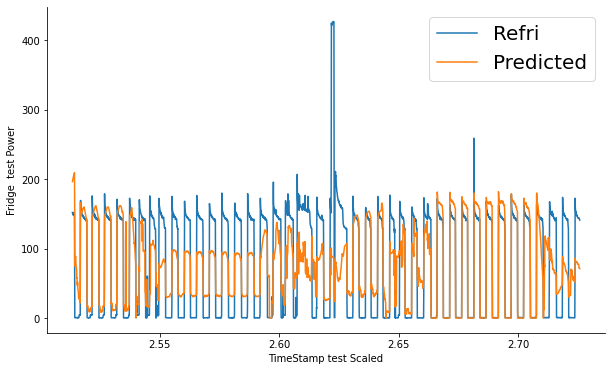

In [48]:
idx = 3000
plt.figure(figsize=(10,6))
# plt.plot(x_test_timestamp[:idx], scalers[].inverse_transform(xt.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], yt.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean_[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()
# savefig("Uncertainity")

In [49]:
model2 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel4,
                      inducing_points).to("cuda")

In [50]:
pred_dist2 = model2.predict(xt[:4000].to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

In [51]:
y_mean2 = scalers[1].inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean2.shape)

torch.Size([16781]) (4000,)


In [52]:
y_mean_ = np.clip(y_mean2,0,y_mean2.max())

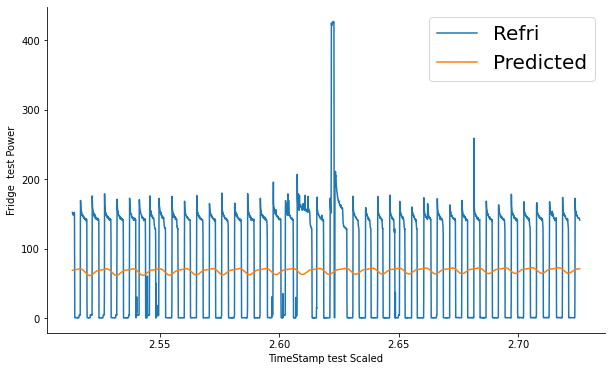

In [53]:
idx = 3000
plt.figure(figsize=(10,6))
# plt.plot(x_test_timestamp[:idx], scaler_y.inverse_transform(y.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], yt.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean_[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

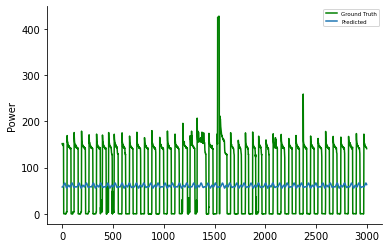

In [42]:
idx = 3000
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx),  yt.cpu().reshape(-1,1)[:idx], label = "Ground Truth", color="green")
plt.plot(jnp.arange(idx), y_mean_[:idx].reshape(-1,1), label = "Predicted")
# for i in range(2,3):
#     plt.fill_between(jnp.arange(idx), y_mean[:idx] - i*y_std[:idx], y_mean[:idx] + i*y_std[:idx],
#                     color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
# plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.legend( prop={'size': 5.5})
plt.ylabel("Power")
sns.despine()

In [22]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  27.80521506352558
RMSE:  44.84471


In [59]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled


In [60]:
os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "./Final_plotss/"

In [62]:
latexify(width_scale_factor=2, fig_height=2)

In [22]:
idx = 2000
# plt.figure(figsize=(10,6))
plt.figure()
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean[300:idx+300], label = "Fridge Predicted")
plt.legend()
sns.despine()
savefig("CombinationKernel")

saving image to ./Final_plotss/CombinationKernel_latexified.pdf
Figure size: [2. 2.]


In [23]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                       inducing_points).to("cuda")

In [24]:
pred_dist1 = model1.predict(xt.to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [25]:
y_mean1 = scalers[1].inverse_transform(y_mean1.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean1.shape)

torch.Size([14780]) (14780,)


In [26]:
idx = 2000
# plt.figure(figsize=(10,6))
plt.figure()
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean1[300:idx+300], label = "Fridge Predicted")
# plt.legend()
sns.despine()
savefig("RBFKernel")

saving image to ./Final_plotss/RBFKernel_latexified.pdf
Figure size: [2. 2.]


In [ ]:
# for name, params in model.named_parameters():
#   print(name, params)

# # model.mll.model.base_covar_module.kernels.base_kernel.raw_lengthscale

In [19]:
x.shape

torch.Size([55457, 100])

In [22]:
model2 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel4,
                       inducing_points).to("cuda")

In [23]:
pred_dist2 = model2.predict(xt.to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


In [24]:
y_mean2 = scaler_y.inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean2.shape)

torch.Size([14780]) (14780,)


In [26]:
idx = 2000
plt.figure()
# plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), yt[300:idx+300], label = "Fridge True")
plt.plot(jnp.arange(idx), y_mean2[300:idx+300], label = "Fridge Predicted")
# plt.legend()
sns.despine()
savefig("RBFxPeriodicKernel")

saving image to ./Final_plotss/RBFxPeriodicKernel_latexified.pdf
Figure size: [2. 2.]


## Normal

In [64]:
# kernel1 = ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=n+1))
# kernel2 = ScaleKernel(MaternKernel(nu=0.5,ard_num_dims=1,active_dims=(99)))
# kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1,active_dims=(99)))
# # kernel5 = ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(num_dims=n,ard_num_dims=n))
# #   theta =  {'base_covar_module.kernels.0.base_kernel.lengthscale': torch.tensor(0.5),
# #         'base_covar_module.kernels.0.outputscale': torch.tensor(5.0),
# #         'base_covar_module.kernels.1.kernels.0.outputscale':torch.tensor(1.0),
# #         'base_covar_module.kernels.1.kernels.0.base_kernel.lengthscale': torch.tensor(0.1),
# #         'base_covar_module.kernels.1.kernels.1.outputscale':torch.tensor(1.0),
# #         'base_covar_module.kernels.1.kernels.1.base_kernel.lengthscale': torch.tensor(1.0),
# #         'base_covar_module.kernels.1.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
# #theta = { 'base_covar_module.kernels.1.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
# kernel4 = kernel2*kernel3
# kernel = kernel1 + kernel4
# # induce_points = 512
# inducing_points =  x[np.arange(0,x.shape[0],95)] 
# # inducing_points = x[torch.randperm(x.shape[0])[: 1500]]

# model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
#                     inducing_points).to("cuda")
# model_name =  "Refrigerator_trial_seq_time.pt"
# model.load_state_dict(torch.load(
#     os.path.join("models/", model_name)))

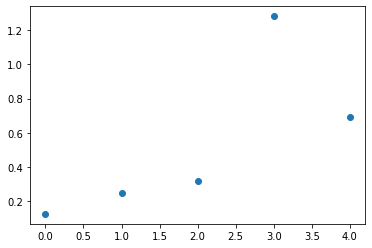

In [65]:
plt.scatter(range(5),model.mll.model.base_covar_module.base_kernel.lengthscale.cpu().detach().reshape(-1,1))

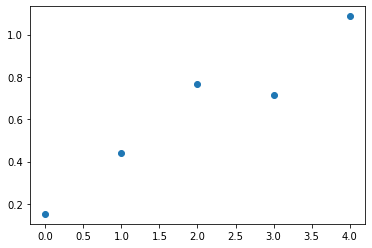

In [15]:
# plt.scatter(range(5),model.mll.model.base_covar_module.kernels[0].base_kernel.lengthscale.cpu().detach().reshape(-1,1)[:5])

In [66]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([-1.6414], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([0.1491], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.raw_outputscale Parameter containing:
tensor(-1.8641, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[-2.0170, -1.2695, -0.9937,  0.9573,  0.0039]], device='cuda:0',
       requires_grad=True)
mll.model.covar_module.inducing_points Parameter containing:
tensor([[-0.1683, -0.2927, -0.2738, -0.4608, -0.7328],
        [ 0.4291,  0.2614, -0.0847, -0.3989, -0.4386],
        [ 0.1252, -0.1534,  0.5574,  2.2636,  2.2354],
        ...,
        [ 5.0900,  6.5897,  1.9888,  0.2504, -2.9582],
        [ 0.2647,  2.4551,  1.7340, -0.4533, -0.4453],
        [ 0.1507,  0.7939,  1.4491,  0.1928,  0.5327]], device='cuda:0',
       dtype=torch.float64, requires_grad=True)


In [67]:
# import numpy as np
# try:
#     from probml_utils import latexify, savefig, is_latexify_enabled
# except ModuleNotFoundError:
#     %pip install git+https://github.com/probml/probml-utils.git
#     from probml_utils import latexify, savefig, is_latexify_enabled


# os.environ["LATEXIFY"] = "1"
# os.environ["FIG_DIR"] = "./Final_plotss/"

# latexify(width_scale_factor=2, fig_height=2)


In [68]:
# import seaborn as sns
# import matplotlib.pyplot as plt

In [69]:
# arr = np.array([3.8464, 4.5094, 4.7394, 4.9024, 4.9117, 5.0150, 4.8746, 4.9372, 4.3143,
#          4.5656, 5.0050, 5.1365, 5.1490, 5.2152, 5.2837, 5.2594, 5.1965, 5.0747,
#          5.1212, 4.8200, 4.6431, 4.8732, 4.7529, 0.3853, 4.4826, 4.9550, 5.0677,
#          5.2859, 4.9612, 5.1401, 5.2131, 4.4774, 4.5654, 4.5685, 3.8310, 3.0889,
#          2.7822, 4.0948, 4.0399, 4.6180, 4.5923, 4.5015, 4.0521, 4.8423, 5.2143,
#          5.4020, 4.8021, 4.5021, 0.6626, 0.1252, 1.3779, 4.8821, 4.6781, 4.8554,
#          4.5223, 4.5568, 5.0172, 5.4072, 5.0706, 4.5916, 4.5663, 4.1121, 4.2572,
#          4.2228, 3.7784, 0.4839, 3.6554, 4.3523, 4.6682, 4.6549, 4.8291, 5.0260,
#          4.7748, 4.5609, 4.4541, 4.4165, 4.4292, 4.1279, 3.6382, 4.1110, 4.7252,
#          5.0184, 5.0391, 5.2424, 5.5062, 5.4739, 5.5326, 5.6874, 5.6897, 5.4765,
#          5.4602, 5.4513, 5.5450, 5.6225, 5.5479, 5.3580, 5.3926, 5.1536, 4.6321])
# ar1 = np.arange(0,99,1)
# plt.plot(ar1,arr,'b')
# plt.xlabel('ARD')
# plt.ylabel('Learned ARD LengthScale values')
# # plt.title("Building 6 Test")

# plt.show()
# sns.despine()
# savefig("ARD_Ref")


In [70]:
pred_dist = model.predict(xt.to("cuda"))

In [71]:
y_mean = pred_dist.loc

In [72]:
y_mean = scalers[1].inverse_transform(y_mean.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(yt.shape, y_mean.shape)

torch.Size([16781]) (16781,)


In [73]:
y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

Text(0, 0.5, 'Raw Error on Test')

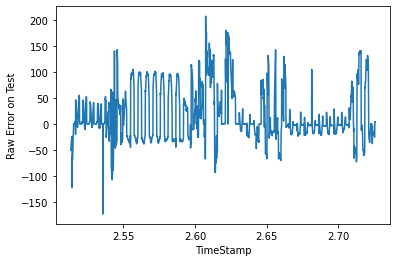

In [74]:
idx=3000
mae_arr = (np.array(yt) - y_mean)
# mae_arr = np.abs(np.array(yt) - y_mean)
plt.plot(x_test_timestamp[:idx],mae_arr[:idx])
plt.xlabel("TimeStamp")
plt.ylabel("Raw Error on Test")

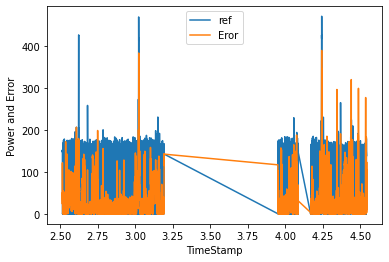

In [75]:
idx=yt.shape[0]
mae_arr = np.abs(np.array(yt) - y_mean)
plt.plot(x_test_timestamp[:idx],yt[:idx], label = "ref")
plt.plot(x_test_timestamp[:idx],mae_arr[:idx], label="Eror")
plt.xlabel("TimeStamp")
plt.ylabel("Power and Error")
plt.legend()

<AxesSubplot:ylabel='Density'>

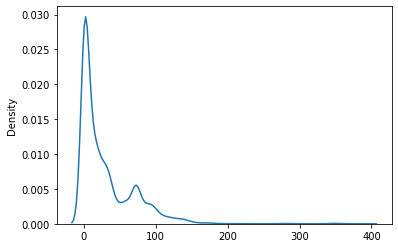

In [76]:
sns.kdeplot(mae_arr)

Text(0, 0.5, 'Absolute Error on Test')

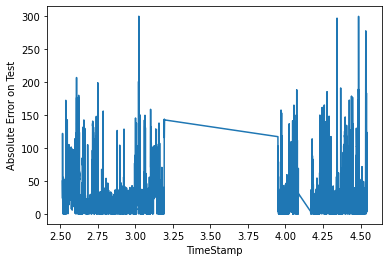

In [77]:
mae_arr1 = []


for i in range(len(mae_arr)):
  if (mae_arr[i]>300):
    mae_arr1.append(0)
  else:
    mae_arr1.append(mae_arr[i])

np.mean(mae_arr1)

plt.plot(x_test_timestamp[:],mae_arr1[:])
plt.xlabel("TimeStamp")
plt.ylabel("Absolute Error on Test")

In [78]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  30.236938220842944
RMSE:  49.22505


In [25]:
#MAE:  28.1036

In [26]:
# x1 = xt[:,49]

In [27]:
# scalers[0].inverse_transform(x[:,:99]).min()

In [22]:
x1 = x_test_features[:,0].reshape(-1,1)

In [23]:
x2 =  x_test_features[:,1].reshape(-1,1)

In [30]:

# x3 = x_train_features[:,0].reshape(-1,1)
# x4 =  x_train_features[:,1].reshape(-1,1)
# print(x4.min())
# idx = 5000
# plt.figure(figsize=(10,6))
# plt.plot(x_train_timstamp[:idx], scalers[3].inverse_transform(x3)[:idx], label = "Main")
# plt.legend()
# plt.title("Train")

In [31]:
# idx = 3000
# plt.figure(figsize=(10,6))
# plt.plot(x_test_timestamp[:idx], scalers[3].inverse_transform(x1)[:idx], label = "Main")
# plt.plot(x_test_timestamp[:idx], scalers[-1].inverse_transform(x2)[:idx], label = "Main Ref Dif")
# plt.legend()
# plt.title("Test")

In [32]:
y_mean.min()

0.0

4.4086485e-07


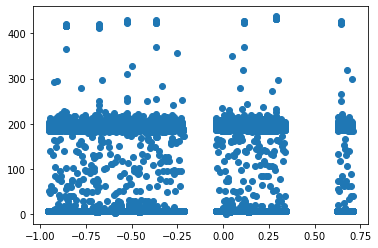

In [33]:
y_train1 = scalers[1].inverse_transform(y_train.reshape(-1,1))
print(y_train1.min())
plt.scatter(x_train_timstamp[:idx], y_train1[:idx], label = "Refri")

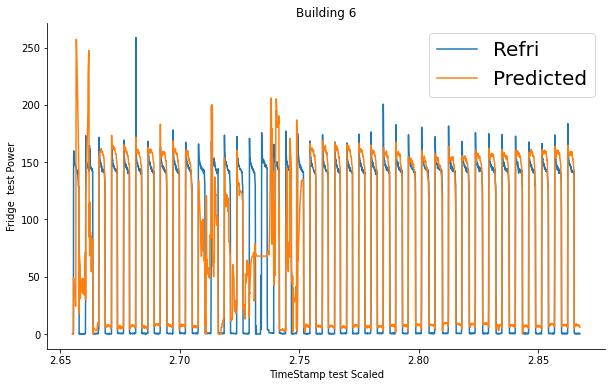

In [24]:
idx = 3000#x2.shape[0]
start = 2000
plt.figure(figsize=(10,6))
# plt.plot(x_test_timestamp[:idx], scalers[3].inverse_transform(x1)[:idx], label = "Main")
# plt.plot(x_test_timestamp[:idx], scalers[-1].inverse_transform(x2)[:idx], label = "Main Ref Dif")
plt.plot(x_test_timestamp[start:start+idx], yt.cpu()[start:start+idx], label = "Refri")
plt.plot(x_test_timestamp[start:start+idx], y_mean[start:start+idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
plt.title("Building 6")
sns.despine()

In [35]:
value, count = np.unique(y_mean, return_counts=True)

Z = [x for _,x in sorted(zip(value,count))]

value[13000:14000].max(), count[13000:14000].max()

(418.69868118612675, 1)

In [39]:
y_mean1 = np.array(y_mean)
for i in range(len(y_mean)):

  # if y_mean1[i]>80 and y_mean[i]<120:
  if y_mean[i]>100:
    y_mean1[i] = 145
  if y_mean1[i]<100:
    y_mean1[i] = 0

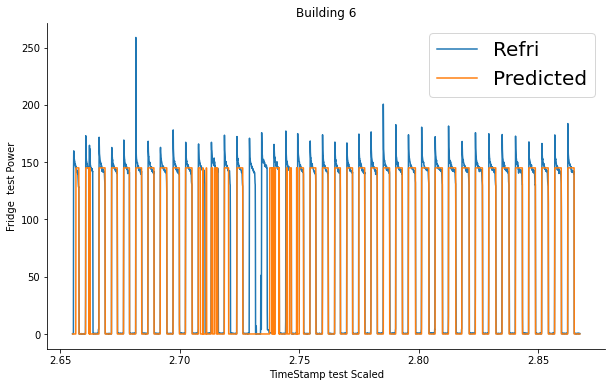

In [40]:
index = 3000
start = 2000
plt.figure(figsize=(10,6))
# plt.plot(x_test_timestamp[:idx], scalers[3].inverse_transform(x1)[:idx], label = "Main")
# plt.plot(x_test_timestamp[:idx], scalers[-1].inverse_transform(x2)[:idx], label = "Main Ref Dif")
plt.plot(x_test_timestamp[start:start+index], yt.cpu()[start:start+index], label = "Refri")
plt.plot(x_test_timestamp[start:start+index], y_mean1[start:start+index], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
plt.title("Building 6")
sns.despine()

In [41]:
mae = np.mean(np.abs(np.array(yt) - y_mean1))
rms = errors.rmse(jnp.array(yt), y_mean1)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  27.386141059540915
RMSE:  62.59981


In [ ]:
# idx = 3000
# plt.figure(figsize=(10,6))
# plt.plot(jnp.arange(idx), scaler_y.inverse_transform(y.cpu().reshape(-1,1))[:idx], label = "Main")
# plt.plot(jnp.arange(idx), yt.cpu()[:idx], label = "Refri")
# plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
# plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
# plt.xlabel("Indexes")
# plt.ylabel("Fridge Power")
# sns.despine()

In [20]:
# plt.plot(np.array(test_timestamp_orig)[:300],np.array(yt)[:300])
# plt.plot(np.array(test_timestamp_orig)[:300],np.array(y_mean)[:300])

In [21]:
# plt.scatter(np.array(test_timestamp_orig)[:3000],np.array(y_mean)[:3000],label="True")
# plt.scatter(np.array(test_timestamp_orig)[:3000],np.array(yt)[:3000],label="Pred")
# plt.legend()
# plt.xlabel("TimeStamp")
# plt.xlabel("Refrogerator Power")

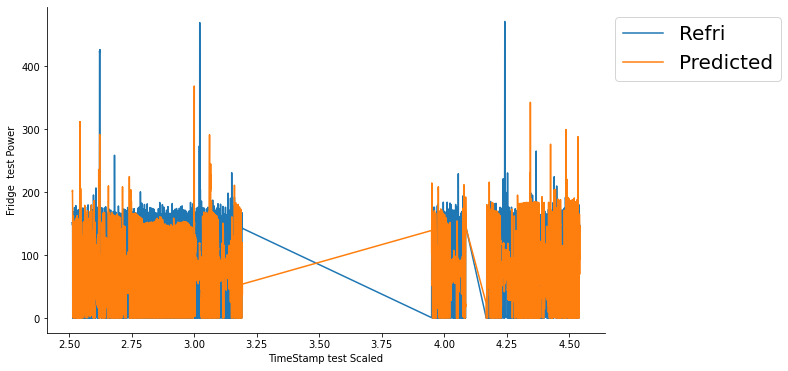

In [22]:
idx = x_test.shape[0]
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp, y_test[:idx], label = "Refri")
plt.plot(x_test_timestamp, y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()
# savefig("CombinationKernel")
# plt.savefig("./Results/Refrigerator_building5.png", bbox_inches="tight")

In [27]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [ ]:
pred_dist1 = model.predict(torch.tensor(np.array(x_train_full)).to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [ ]:
y_mean1 = scaler_y.inverse_transform(y_mean1.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_train.shape, y_mean1.shape)

In [ ]:
mae = np.mean(np.abs(np.array(y_train) - y_mean1))
rms = errors.rmse(jnp.array(y_train), y_mean1)

print("MAE: ", mae)
print("RMSE: ", rms)

In [ ]:
idx = x_train.shape[0]
plt.figure(figsize=(10,6))
plt.plot(x_train_timstamp, y_train[:idx], label = "Refri")
plt.plot(x_train_timstamp, y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()
# savefig("CombinationKernel")
# plt.savefig("./Results/Refrigerator_building5.png", bbox_inches="tight")

In [ ]:
#MAE:  39.81858310475401 build 6
#MAE:  30.333733374869247 build 3
#MAE:  37.32115756605644 build 2
#MAE: 43.212248588857065 build 5
#MAE:  48.917852990726765

In [ ]:
# MAE: Building 6 MAE: 35.07
# MAE: Building 3 MAE:  31.565
# MAE: Building 2 MAE: 31.089
# MAE: Building 1 MAE: 37.3657
# MAE: Building 5 MAE:  46.316869

In [ ]:
# MAE: Building 6 MAE: 34.3709125
# MAE: Building 3 MAE: 30.919
# MAE: Building 2 MAE: 30.43776
# MAE: Building 1 MAE: 37.10209
# MAE: Building 5 MAE: 45.02767

In [ ]:
26.442985, 27.0600
